## Analizing Air Quality Data in India (2017 - 2022): https://www.kaggle.com/datasets/fedesoriano/air-quality-data-in-india

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

# Models
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [10]:
df = pd.read_csv('air-quality-india.csv')
df.head()

,Timestamp,Year,Month,Day,Hour,PM2.5
0,2017-11-07 12:00:00,2017,11,7,12,64.51
1,2017-11-07 13:00:00,2017,11,7,13,69.95
2,2017-11-07 14:00:00,2017,11,7,14,92.79
3,2017-11-07 15:00:00,2017,11,7,15,109.66
4,2017-11-07 16:00:00,2017,11,7,16,116.50


In [11]:
# Saving original DataFrame
original_df = df

# 1. Data analyzing

## Dropping unnecessary columns and making DataTime column as an index

In [12]:
# Making Timestamp column as insex
df.set_index(df['Timestamp'], inplace=True)
df.drop(['Timestamp', 'Year', 'Month', 'Day', 'Hour'], axis=1, inplace=True)

# changing dtype of index -> to data_tyme format
df.index = pd.to_datetime(df.index)
df.head()

,PM2.5
Timestamp,
2017-11-07 12:00:00,64.51
2017-11-07 13:00:00,69.95
2017-11-07 14:00:00,92.79
2017-11-07 15:00:00,109.66
2017-11-07 16:00:00,116.50


In [13]:
# checking dtype of the index column
df.index.dtype

dtype('<M8[ns]')

In [14]:
# renaming the target column

df.rename(columns={"PM2.5": "pm"}, inplace=True)
#df.head()
df.describe()

,pm
count,36192.000000
mean,49.308429
std,24.863511
min,7.020000
25%,28.080000
50%,45.730000
75%,64.520000
max,245.630000


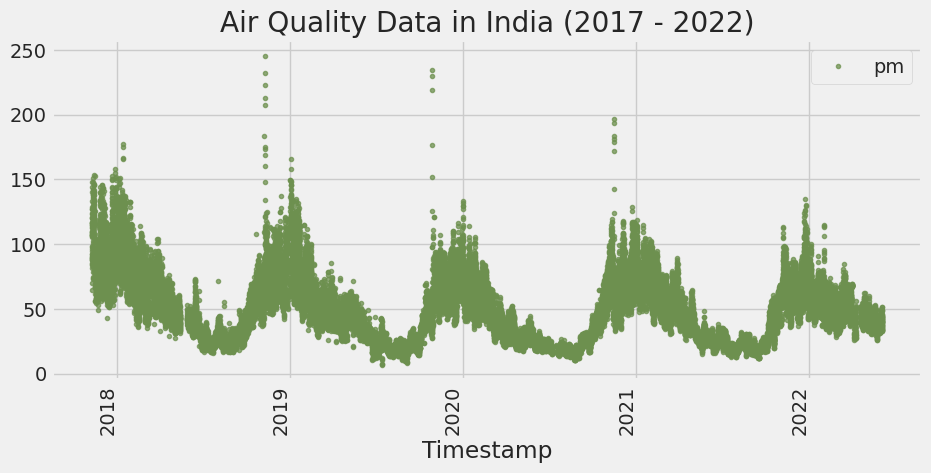

In [15]:
# Plotting our data
df.plot(style='.',
        alpha=0.75, rot=90,
        figsize=(10, 5),
        color=color_pal[3],
        title='Air Quality Data in India (2017 - 2022)')
plt.show()

# 2. Data cleaning

## Finding outliers and removing them

<Axes: ylabel='Frequency'>

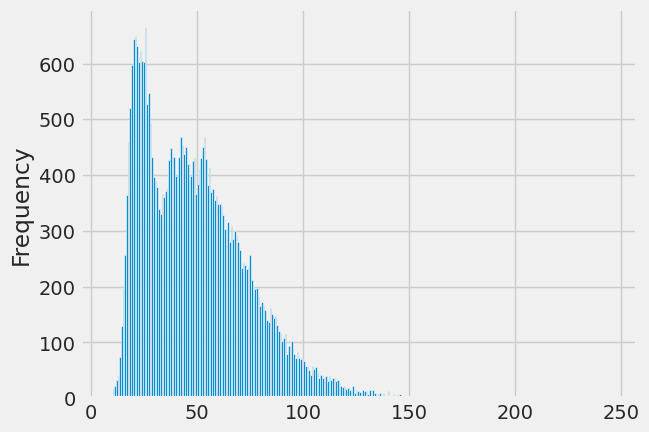

In [16]:
# Ploting the range of target values
df.pm.plot(kind='hist', bins=300)

<Axes: title={'center': 'Outliers'}, xlabel='Timestamp'>

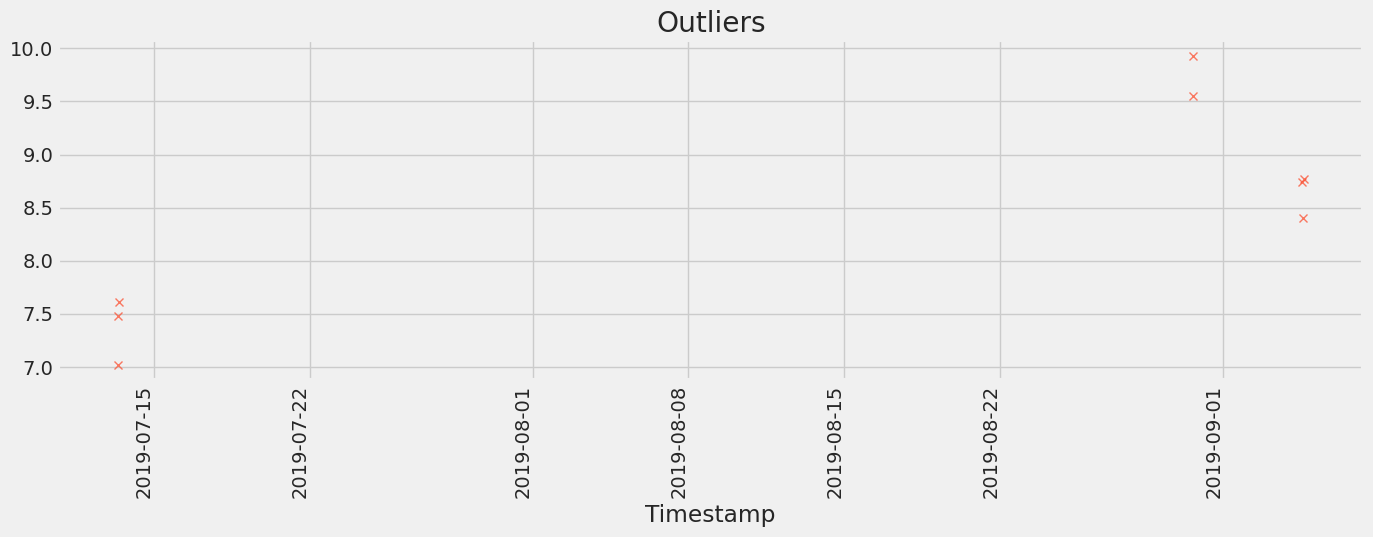

In [17]:
df.query('pm <= 10')['pm'] \
    .plot(style='x',
          alpha=0.75, rot=90,
          figsize=(15, 5),
          color=color_pal[1],
          title='Outliers')

In [18]:
df.query('pm <= 10').index

DatetimeIndex(['2019-07-13 09:00:00', '2019-07-13 10:00:00',
               '2019-07-13 11:00:00', '2019-08-30 15:00:00',
               '2019-08-30 16:00:00', '2019-09-04 13:00:00',
               '2019-09-04 14:00:00', '2019-09-04 15:00:00'],
              dtype='datetime64[ns]', name='Timestamp', freq=None)

### We may see that there were only a few hours during three dates with such low values. Assume that on the listed time sensors were not working. So let's remove that data from the Data Frame

<Axes: title={'center': 'Outliers'}, xlabel='Timestamp'>

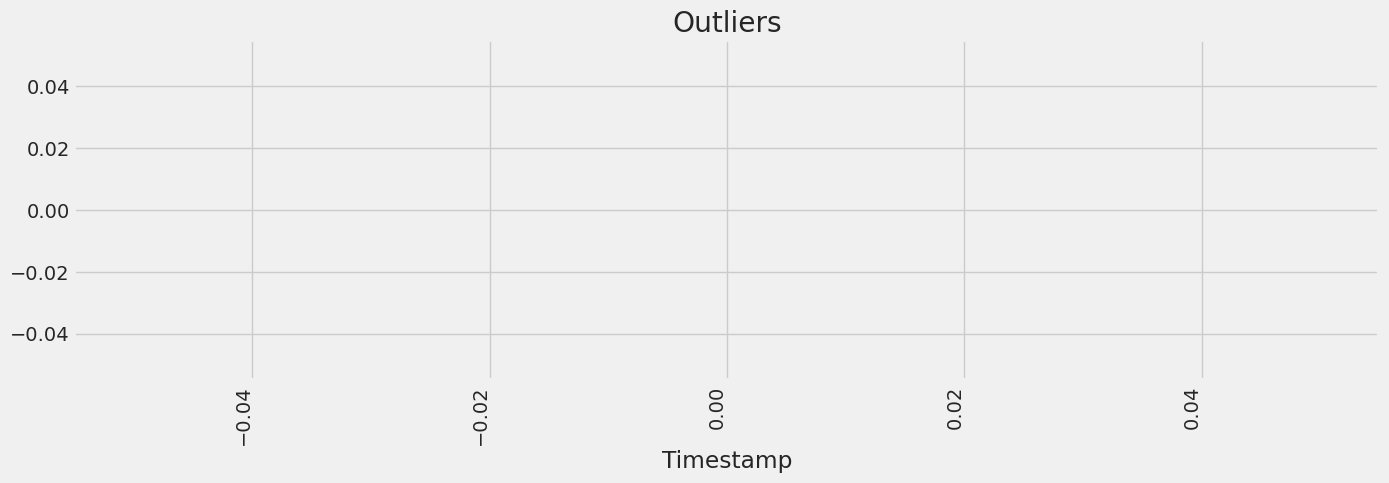

In [19]:
df = df.query('pm > 10').copy()
df.query('pm < 10')['pm'] \
    .plot(style='x',
          alpha=0.75, rot=90,
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')

<Axes: title={'center': 'Outliers'}, xlabel='Timestamp'>

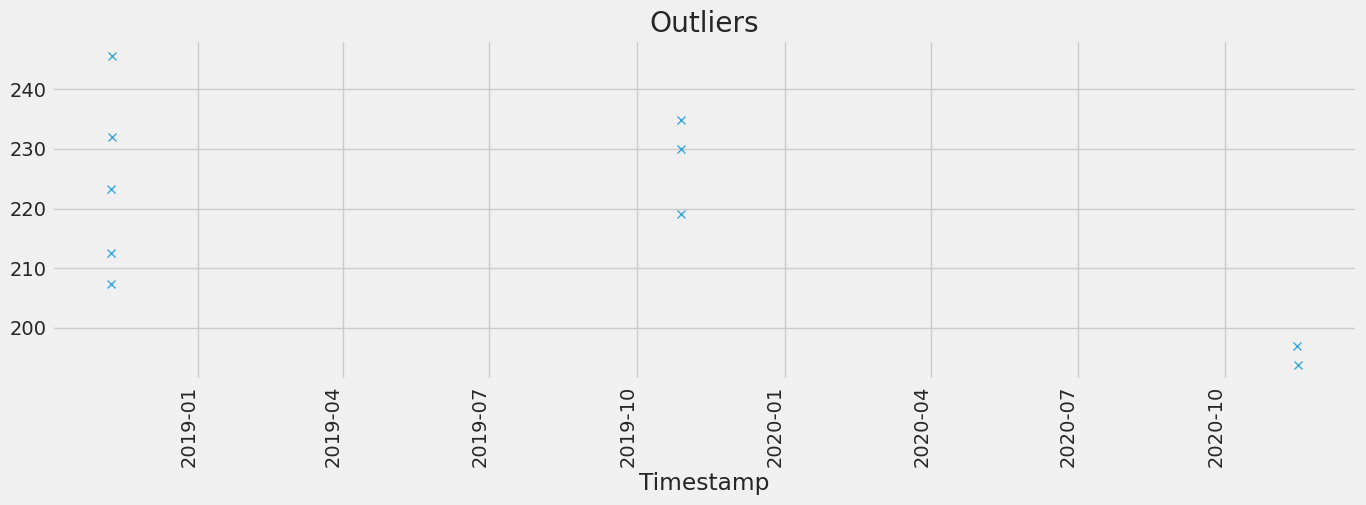

In [20]:
df.query('pm > 190')['pm'] \
    .plot(style='x',
          alpha=0.75, rot=90,
          figsize=(15, 5),
          color=color_pal[0],
          title='Outliers')

In [21]:
df.query('pm > 195').index

DatetimeIndex(['2018-11-07 18:00:00', '2018-11-07 19:00:00',
               '2018-11-07 20:00:00', '2018-11-07 21:00:00',
               '2018-11-07 22:00:00', '2019-10-27 23:00:00',
               '2019-10-28 00:00:00', '2019-10-28 01:00:00',
               '2020-11-14 19:00:00'],
              dtype='datetime64[ns]', name='Timestamp', freq=None)

### We may see that there were only a few hours during tree short periods with such high values. Assume that on the listed time sensors were working improperly. So let's remove that data too

<Axes: title={'center': 'Outliers'}, xlabel='Timestamp'>

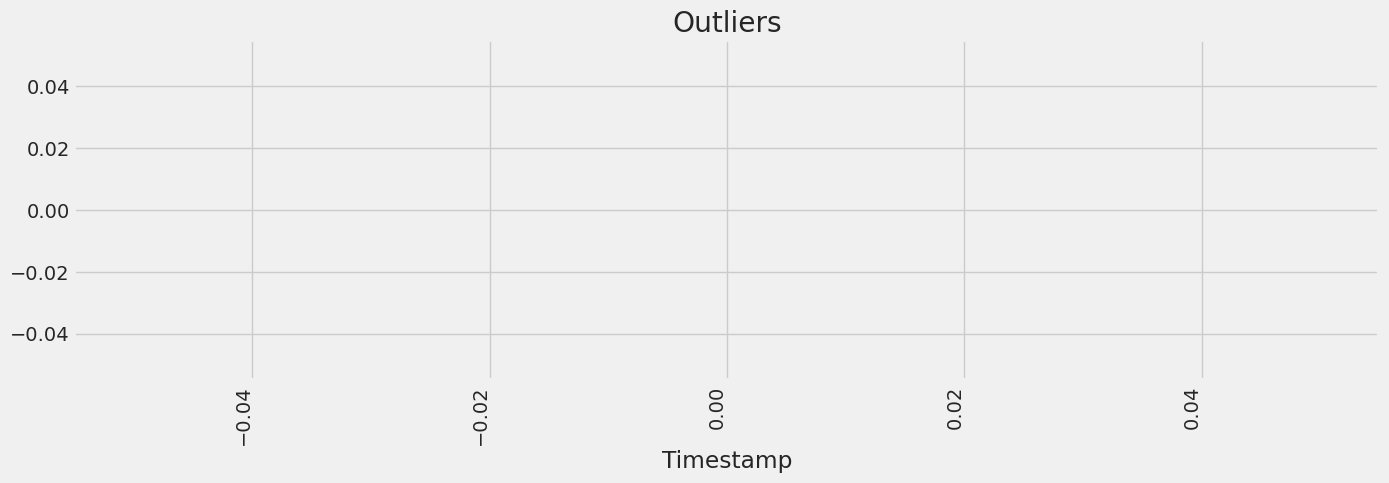

In [22]:
df = df.query('pm <= 195').copy()
df.query('pm > 200')['pm'] \
    .plot(style='x',
          alpha=0.75, rot=90,
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')

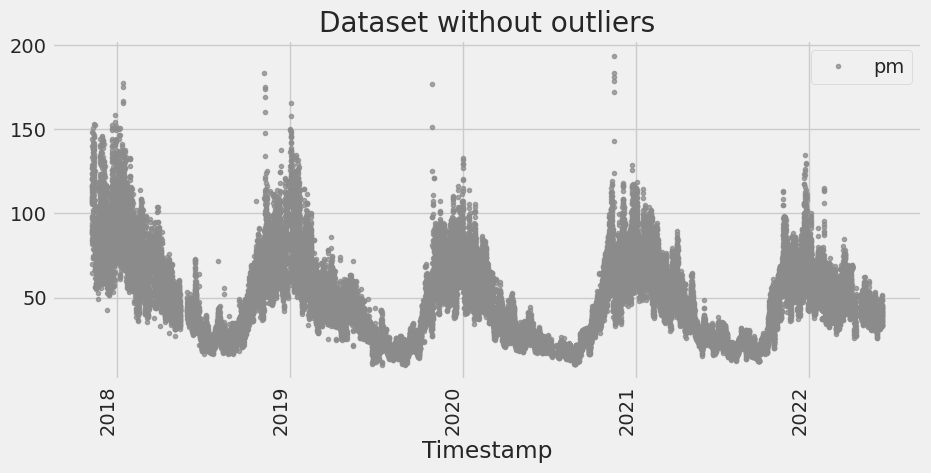

In [23]:
# Plotting clear data
df.plot(style='.',
        alpha=0.75, rot=90,
        figsize=(10, 5),
        color=color_pal[4],
        title='Dataset without outliers')
plt.show()

## Saving clear dataset without outliers

In [24]:
clear_df = df.copy()

# Checking dtype of index column
print(f"Dtype of index column is: {clear_df.index.dtype}\nIt's shape is: {clear_df.shape}")

Dtype of index column is: datetime64[ns]
It's shape is: (36175, 1)


# 3. Train / Test Split

In [25]:
split_data = '2021-07-01 12:00:00'
train = df.loc[df.index <= split_data].copy()
test = df.loc[df.index > split_data].copy()

print(f"Training set got {train.shape[0]} records")
print(f"Testing set got {test.shape[0]} records")
print(f"Test DF is {round(test.shape[0] / df.shape[0] * 100, 2)}% of main DF")

Training set got 28902 records
Testing set got 7273 records
Test DF is 20.11% of main DF


## Analyzing Train and Test Datasets

In [26]:
train.describe()

,pm
count,28902.000000
mean,50.455891
std,25.682851
min,10.210000
25%,28.480000
50%,46.190000
75%,66.870000
max,193.800000


In [27]:
test.describe()

,pm
count,7273.000000
mean,44.579308
std,19.706758
min,12.340000
25%,25.680000
50%,44.440000
75%,57.640000
max,134.540000


In [28]:
df_checking = df.copy()
df_checking['date'] = df_checking.index

df_checking_trainDF = df_checking.loc[df.index <= split_data].copy()
print(f"First date is {df_checking_trainDF.iloc[0].date}")
print(f"Last date is {df_checking_trainDF.iloc[-1].date}")

First date is 2017-11-07 12:00:00
Last date is 2021-07-01 12:00:00


In [29]:
df_checking_testDF = df_checking.loc[df.index > split_data].copy()
print(f"First date is {df_checking_testDF.iloc[0].date}")
print(f"Last date is {df_checking_testDF.iloc[-1].date}")

First date is 2021-07-01 13:00:00
Last date is 2022-06-04 15:00:00


## Plotting Train and Test DataSets

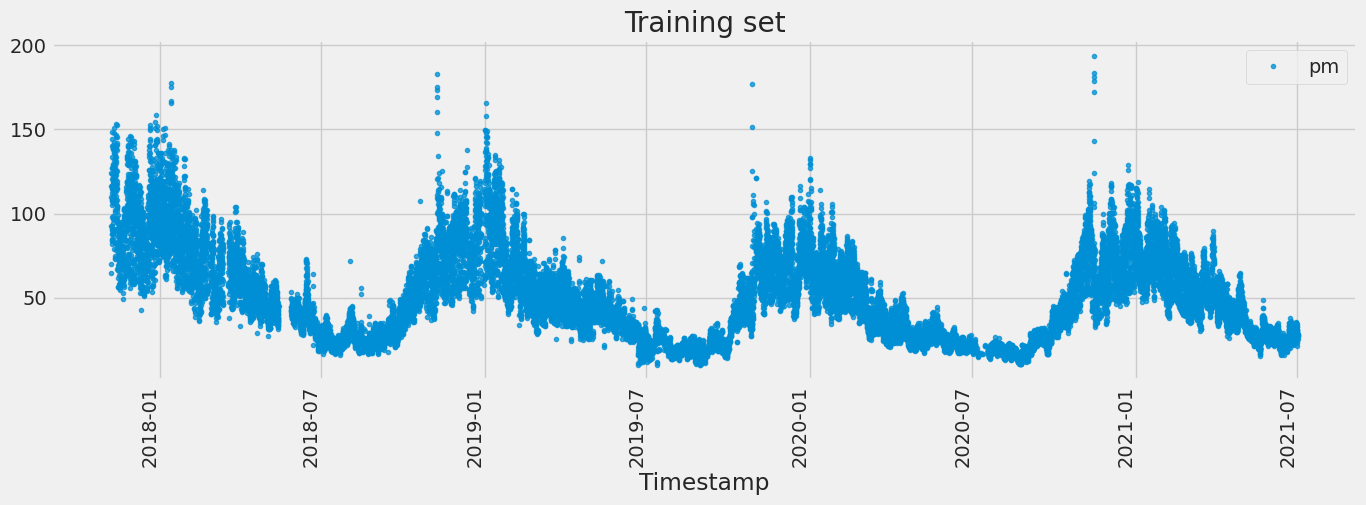

In [30]:
train.plot(style='.',
        alpha=0.75, rot=90,
        figsize=(15, 5),
        color=color_pal[0],
        title='Training set')
plt.show()

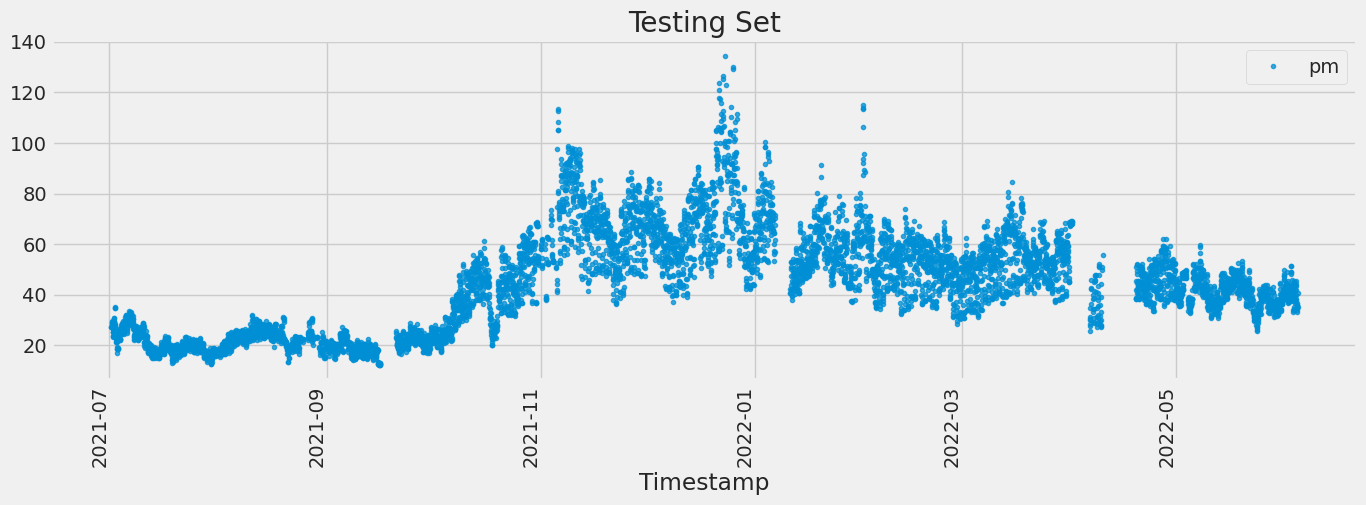

In [31]:
test.plot(style='.',
        alpha=0.75, rot=90,
        figsize=(15, 5),
        color=color_pal[0],
        title='Testing Set')
plt.show()

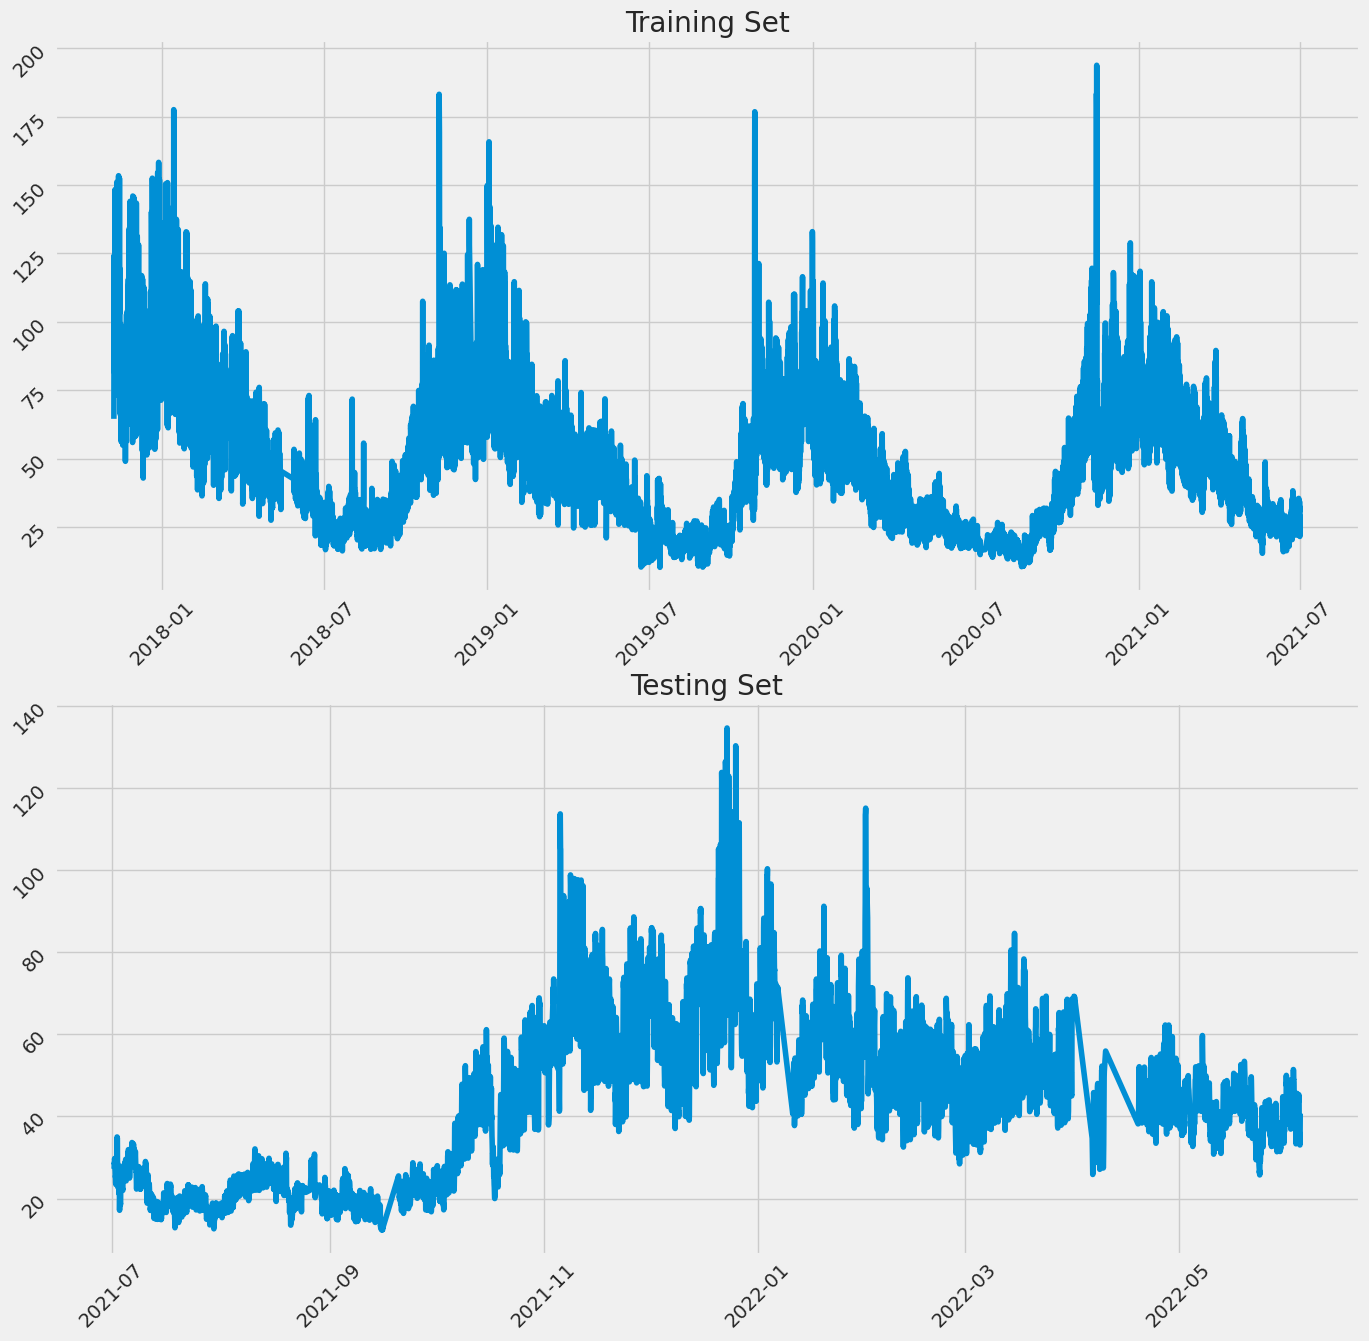

In [32]:
figure, axis = plt.subplots(2, 1)
figure.set_figheight(15)
figure.set_figwidth(15)

X1 = train.index
Y1 = train.pm
axis[0].plot(X1, Y1)
axis[0].set_title("Training Set")
axis[0].tick_params(labelrotation=45)

X2 = test.index
Y2 = test.pm
axis[1].plot(X2, Y2)
axis[1].set_title("Testing Set")
axis[1].tick_params(labelrotation=45)
#plt.xticks(rotation=45, ha='right')

plt.show()

# 4. Feature Engineering

## Data_tipe features

In [33]:

def create_features(df):
    df['date'] = df.index
    df['date'] = pd.to_datetime(df.date)
    df['hour'] = df['date'].dt.hour
    df['day_of_week'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['day_of_year'] = df['date'].dt.dayofyear
    df['day_of_month'] = df['date'].dt.day
    df['week_of_year'] = df['date'].dt.isocalendar().week
    df.drop(['date'], axis=1, inplace=True)

    #Mooving target to the end of the DataFrame
    df = df.reindex(columns = [col for col in df.columns if col != 'pm'] + ['pm'])
    return df

df = create_features(df)

df.head()

,hour,day_of_week,quarter,month,year,day_of_year,day_of_month,week_of_year,pm
Timestamp,,,,,,,,,
2017-11-07 12:00:00,12,1,4,11,2017,311,7,45,64.51
2017-11-07 13:00:00,13,1,4,11,2017,311,7,45,69.95
2017-11-07 14:00:00,14,1,4,11,2017,311,7,45,92.79
2017-11-07 15:00:00,15,1,4,11,2017,311,7,45,109.66
2017-11-07 16:00:00,16,1,4,11,2017,311,7,45,116.50


### Saving current DataFrame

In [34]:
clear_df_plus_dt_features = df.copy()
clear_df_plus_dt_features.head()

,hour,day_of_week,quarter,month,year,day_of_year,day_of_month,week_of_year,pm
Timestamp,,,,,,,,,
2017-11-07 12:00:00,12,1,4,11,2017,311,7,45,64.51
2017-11-07 13:00:00,13,1,4,11,2017,311,7,45,69.95
2017-11-07 14:00:00,14,1,4,11,2017,311,7,45,92.79
2017-11-07 15:00:00,15,1,4,11,2017,311,7,45,109.66
2017-11-07 16:00:00,16,1,4,11,2017,311,7,45,116.50


## Lag Features

In [35]:
def add_lags(df):
    target_map = df['pm'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [36]:
df = add_lags(df)

In [37]:
df.tail()

,hour,day_of_week,quarter,month,year,day_of_year,day_of_month,week_of_year,pm,lag1,lag2,lag3
Timestamp,,,,,,,,,,,,
2022-06-04 11:00:00,11,5,2,6,2022,155,4,22,35.89,23.49,19.53,27.59
2022-06-04 12:00:00,12,5,2,6,2022,155,4,22,33.83,22.21,20.26,27.39
2022-06-04 13:00:00,13,5,2,6,2022,155,4,22,33.05,22.44,20.96,28.79
2022-06-04 14:00:00,14,5,2,6,2022,155,4,22,35.29,23.45,21.34,29.38
2022-06-04 15:00:00,15,5,2,6,2022,155,4,22,40.67,24.05,24.12,27.93


### Saving current DataFrame

In [38]:
clear_df_plus_dt_features_plus_lags = df.copy()
clear_df_plus_dt_features_plus_lags.tail()

,hour,day_of_week,quarter,month,year,day_of_year,day_of_month,week_of_year,pm,lag1,lag2,lag3
Timestamp,,,,,,,,,,,,
2022-06-04 11:00:00,11,5,2,6,2022,155,4,22,35.89,23.49,19.53,27.59
2022-06-04 12:00:00,12,5,2,6,2022,155,4,22,33.83,22.21,20.26,27.39
2022-06-04 13:00:00,13,5,2,6,2022,155,4,22,33.05,22.44,20.96,28.79
2022-06-04 14:00:00,14,5,2,6,2022,155,4,22,35.29,23.45,21.34,29.38
2022-06-04 15:00:00,15,5,2,6,2022,155,4,22,40.67,24.05,24.12,27.93


### Creating lists of basic feutures' and target's names

In [39]:
FEATURES = [
    'hour',
    'day_of_week',
    'quarter',
    'month',
    'year',
    'day_of_year',
    'day_of_month',
    #'week_of_year',
]

TARGET = 'pm'

# 5. Training models

## Time Series Cross Validation

In [40]:
tss = TimeSeriesSplit(n_splits=4, test_size=24*365*1, gap=24)
df = df.sort_index()

fold = 0
preds = []
scores = []

In [41]:
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = [
        'hour',
        'day_of_week',
        'quarter',
        'month',
        'year',
        'day_of_year',
        'day_of_month',
        
        #'week_of_year',
        'lag1',
        'lag2',
        'lag3'
        ]

    TARGET = 'pm'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.001)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=50)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[06:50:47] WARNING: /croot/xgboost-split_1675457761144/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:97.13267	validation_1-rmse:63.03600
[50]	validation_0-rmse:92.55604	validation_1-rmse:58.86681


/tmp/ipykernel_48909/637297349.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df.index
/tmp/ipykernel_48909/637297349.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df.date)
/tmp/ipykernel_48909/637297349.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

[100]	validation_0-rmse:88.20768	validation_1-rmse:54.87886
[150]	validation_0-rmse:84.07515	validation_1-rmse:50.95419
[200]	validation_0-rmse:80.14772	validation_1-rmse:47.31575
[250]	validation_0-rmse:76.41592	validation_1-rmse:43.96865
[300]	validation_0-rmse:72.87004	validation_1-rmse:40.91564
[350]	validation_0-rmse:69.50126	validation_1-rmse:38.15060
[400]	validation_0-rmse:66.29871	validation_1-rmse:35.67342
[450]	validation_0-rmse:63.25444	validation_1-rmse:33.49196
[500]	validation_0-rmse:60.36317	validation_1-rmse:31.63937
[550]	validation_0-rmse:57.61759	validation_1-rmse:30.14472
[600]	validation_0-rmse:55.01144	validation_1-rmse:28.93284
[650]	validation_0-rmse:52.53209	validation_1-rmse:28.01993
[700]	validation_0-rmse:50.17719	validation_1-rmse:27.36382
[750]	validation_0-rmse:47.94388	validation_1-rmse:26.92122
[800]	validation_0-rmse:45.82137	validation_1-rmse:26.68327
[850]	validation_0-rmse:43.79789	validation_1-rmse:26.62021
[894]	validation_0-rmse:42.10264	validat

/tmp/ipykernel_48909/637297349.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df.index
/tmp/ipykernel_48909/637297349.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df.date)
/tmp/ipykernel_48909/637297349.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

[50]	validation_0-rmse:64.74058	validation_1-rmse:46.91133
[100]	validation_0-rmse:61.76134	validation_1-rmse:44.16411
[150]	validation_0-rmse:58.93558	validation_1-rmse:41.56078
[200]	validation_0-rmse:56.25595	validation_1-rmse:39.09530
[250]	validation_0-rmse:53.71623	validation_1-rmse:36.77948
[300]	validation_0-rmse:51.30502	validation_1-rmse:34.61054
[350]	validation_0-rmse:49.01810	validation_1-rmse:32.56530
[400]	validation_0-rmse:46.85141	validation_1-rmse:30.64725
[450]	validation_0-rmse:44.79842	validation_1-rmse:28.86101
[500]	validation_0-rmse:42.85448	validation_1-rmse:27.19002
[550]	validation_0-rmse:41.01338	validation_1-rmse:25.62622
[600]	validation_0-rmse:39.27044	validation_1-rmse:24.16556
[650]	validation_0-rmse:37.62074	validation_1-rmse:22.80195
[700]	validation_0-rmse:36.05849	validation_1-rmse:21.54533
[750]	validation_0-rmse:34.57785	validation_1-rmse:20.37482
[800]	validation_0-rmse:33.17332	validation_1-rmse:19.28453
[850]	validation_0-rmse:31.84132	validati

/tmp/ipykernel_48909/637297349.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df.index
/tmp/ipykernel_48909/637297349.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df.date)
/tmp/ipykernel_48909/637297349.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

[50]	validation_0-rmse:57.35629	validation_1-rmse:48.19989
[100]	validation_0-rmse:54.76200	validation_1-rmse:45.96650
[150]	validation_0-rmse:52.30141	validation_1-rmse:43.83442
[200]	validation_0-rmse:49.96977	validation_1-rmse:41.81667
[250]	validation_0-rmse:47.76341	validation_1-rmse:39.91777
[300]	validation_0-rmse:45.67133	validation_1-rmse:38.14236
[350]	validation_0-rmse:43.68598	validation_1-rmse:36.49038
[400]	validation_0-rmse:41.80125	validation_1-rmse:34.94710
[450]	validation_0-rmse:40.01230	validation_1-rmse:33.48636
[500]	validation_0-rmse:38.31684	validation_1-rmse:32.09263
[550]	validation_0-rmse:36.71067	validation_1-rmse:30.82620
[600]	validation_0-rmse:35.18791	validation_1-rmse:29.61013
[650]	validation_0-rmse:33.75337	validation_1-rmse:28.49391
[700]	validation_0-rmse:32.40534	validation_1-rmse:27.46712
[750]	validation_0-rmse:31.12696	validation_1-rmse:26.47799
[800]	validation_0-rmse:29.92170	validation_1-rmse:25.53995
[850]	validation_0-rmse:28.78322	validati

/tmp/ipykernel_48909/637297349.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df.index
/tmp/ipykernel_48909/637297349.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df.date)
/tmp/ipykernel_48909/637297349.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

[06:51:34] WARNING: /croot/xgboost-split_1675457761144/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:57.20884	validation_1-rmse:45.65852
[50]	validation_0-rmse:54.61355	validation_1-rmse:43.38811
[100]	validation_0-rmse:52.15146	validation_1-rmse:41.20242
[150]	validation_0-rmse:49.81896	validation_1-rmse:39.13578
[200]	validation_0-rmse:47.60531	validation_1-rmse:37.19018
[250]	validation_0-rmse:45.50777	validation_1-rmse:35.35030
[300]	validation_0-rmse:43.51815	validation_1-rmse:33.63187
[350]	validation_0-rmse:41.63195	validation_1-rmse:32.02530
[400]	validation_0-rmse:39.84761	validation_1-rmse:30.47936
[450]	validation_0-rmse:38.16456	validation_1-rmse:28.89341
[500]	validation_0-rmse:36.57493	validation_1-rmse:27.37928
[550]	validation_0-rmse:35.07073	validation_1-rmse:25.96418
[600]	validation_0-rmse:33.64592	validation_1-rmse:24.62562
[650]	validation_0-rmse:32.29797	validation_1-rmse:23.37896
[700]	v

In [42]:
print(f"Score across folds {np.mean(scores):0.4f}")
print(f"Fold scores:{scores}")

Score across folds 20.3180
Fold scores:[26.618877575409854, 15.733868683230487, 22.43267206627534, 16.48646822914369]


# 6. Predicting using our super-model

### Let's use RGBoost one more time but useing all DataSet's data

In [43]:
df = clear_df.copy()

In [44]:
df.head()

,pm
Timestamp,
2017-11-07 12:00:00,64.51
2017-11-07 13:00:00,69.95
2017-11-07 14:00:00,92.79
2017-11-07 15:00:00,109.66
2017-11-07 16:00:00,116.50


In [45]:
df = create_features(df)
df = add_lags(df)

FEATURES = [
        'hour',
        'day_of_week',
        'quarter',
        'month',
        'year',
        'day_of_year',
        'day_of_month',
        
        #'week_of_year',
        'lag1',
        'lag2',
        'lag3'
        ]
TARGET = 'pm'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=2000,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.1)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

y_pred = reg.predict(X_all)

[06:52:00] WARNING: /croot/xgboost-split_1675457761144/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:49.60718
[100]	validation_0-rmse:9.34769
[200]	validation_0-rmse:8.68943
[300]	validation_0-rmse:8.24216
[400]	validation_0-rmse:7.85560
[500]	validation_0-rmse:7.53468
[600]	validation_0-rmse:7.30688
[700]	validation_0-rmse:7.12068
[800]	validation_0-rmse:6.96198
[900]	validation_0-rmse:6.83994
[1000]	validation_0-rmse:6.72531
[1100]	validation_0-rmse:6.59645
[1200]	validation_0-rmse:6.48612
[1300]	validation_0-rmse:6.39371
[1400]	validation_0-rmse:6.30416
[1500]	validation_0-rmse:6.22394
[1600]	validation_0-rmse:6.13690
[1700]	validation_0-rmse:6.04468
[1800]	validation_0-rmse:5.98123
[1900]	validation_0-rmse:5.92090
[1999]	validation_0-rmse:5.86036


In [46]:
y_pred_df = clear_df.copy()
#y_pred_df.pm = y_pred

In [47]:
y_pred_df.head()

,pm
Timestamp,
2017-11-07 12:00:00,64.51
2017-11-07 13:00:00,69.95
2017-11-07 14:00:00,92.79
2017-11-07 15:00:00,109.66
2017-11-07 16:00:00,116.50


Text(0.5, 1.05, 'Features Correlation of Full Dataset')

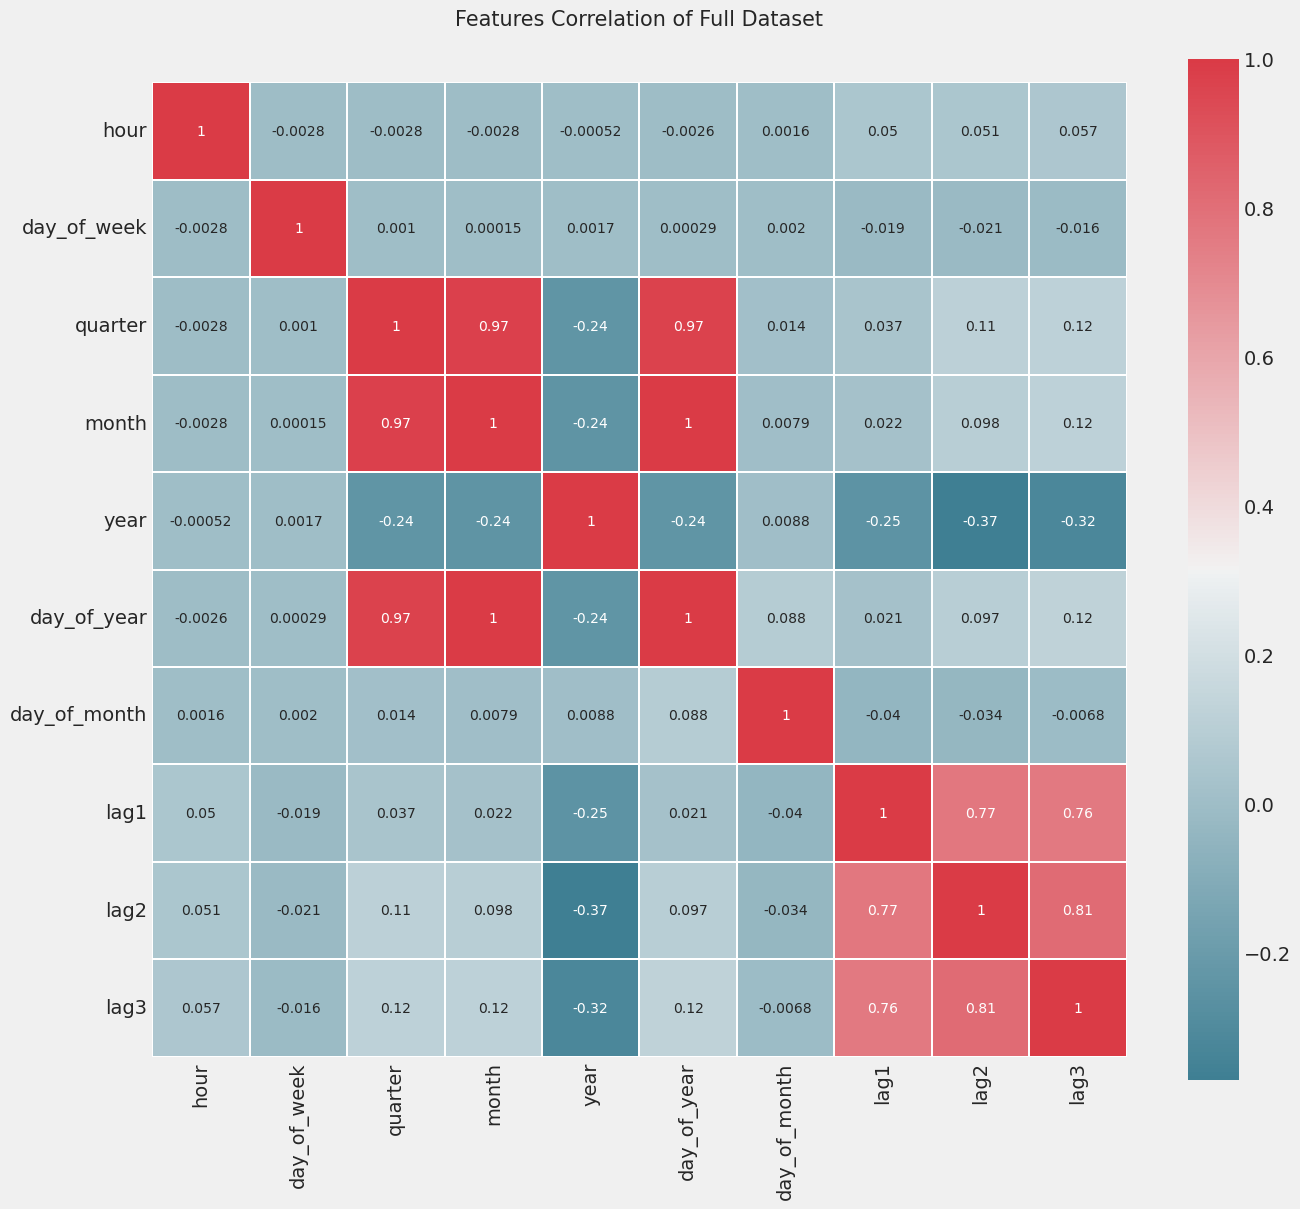

In [48]:
f, ax = plt.subplots(figsize = (14, 14))
colormap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(
    df[FEATURES].corr('pearson'), 
    cmap=colormap,
    square=True, 
    cbar_kws={'shrink': .9}, 
    ax=ax,
    annot=True, 
    linewidths=0.1, vmax=1.0, linecolor='white',
    annot_kws={'fontsize': 10}
)

plt.title('Features Correlation of Full Dataset', y=1.05, size=15)

In [49]:
rgb_score = np.sqrt(mean_squared_error(y_all, y_pred))
print(f"The score when we're using all data is: {rgb_score:.3f}")

The score when we're using all data is: 5.860


In [50]:
# Checking coefficient of determination of the model
print(f"Coefficient of Determination is equel to: {r2_score(clear_df, y_pred):.4f}")

Coefficient of Determination is equel to: 0.9438


In [51]:
#
print(reg.feature_importances_)

[0.08262265 0.01555235 0.00683224 0.02602831 0.15133704 0.37574074
 0.02162283 0.2504807  0.03117608 0.03860703]


In [52]:
features = tuple(FEATURES)
features

('hour',
 'day_of_week',
 'quarter',
 'month',
 'year',
 'day_of_year',
 'day_of_month',
 'lag1',
 'lag2',
 'lag3')

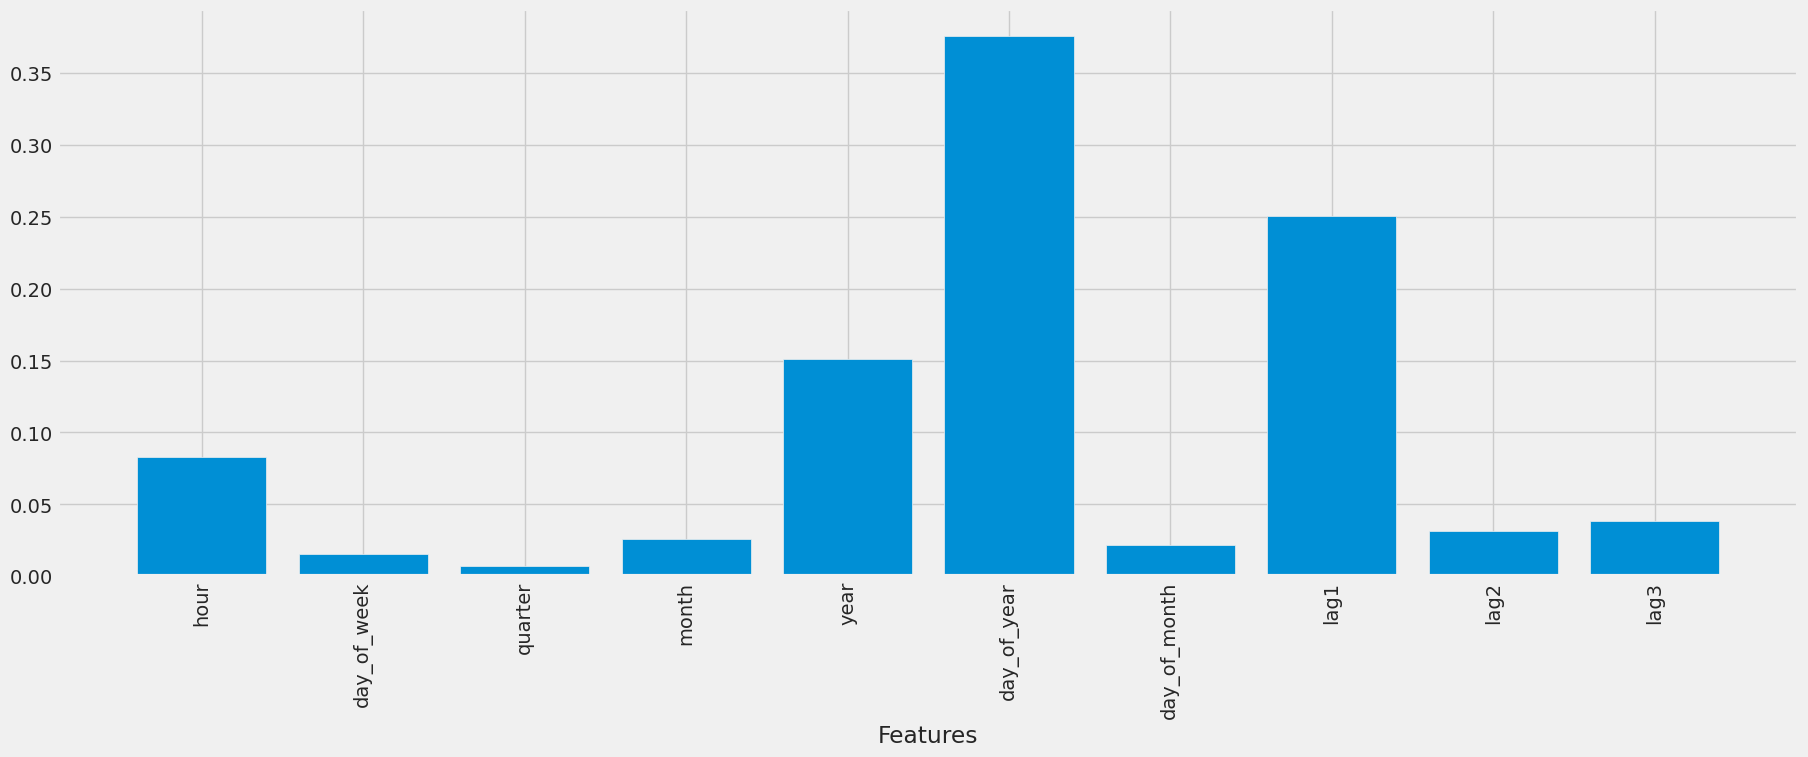

In [53]:
fig, ax = plt.subplots()

features = tuple(FEATURES)
y_pos = np.arange(len(features))

plt.bar(range(len(reg.feature_importances_)), reg.feature_importances_)
ax.set_xticks(y_pos, labels=features)
fig.set_figheight(7)
fig.set_figwidth(20)
plt.xlabel('Features')
plt.xticks(rotation = 90)
plt.show()

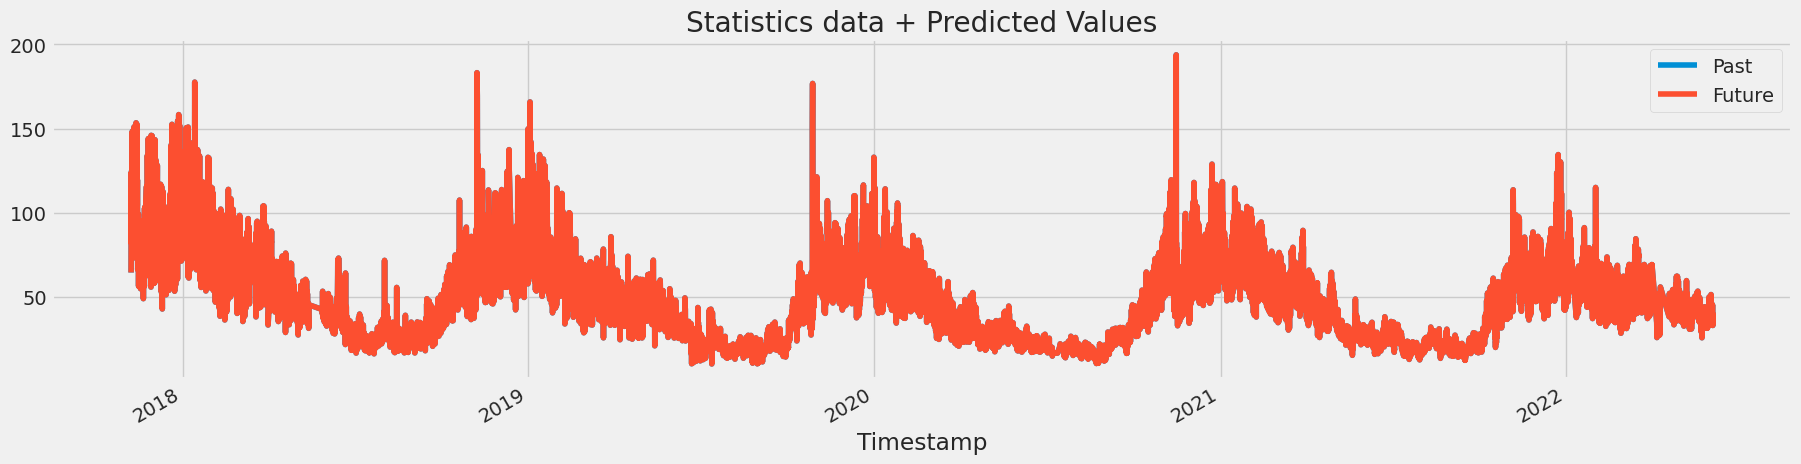

In [54]:
fig, ax = plt.subplots(figsize=(20, 5))
clear_df.plot(ax=ax, label='Original DataSet', title='Statistics data + Predicted Values')
y_pred_df.plot(ax=ax, label='Future Prediction')
ax.legend(['Past', 'Future'])
plt.show()

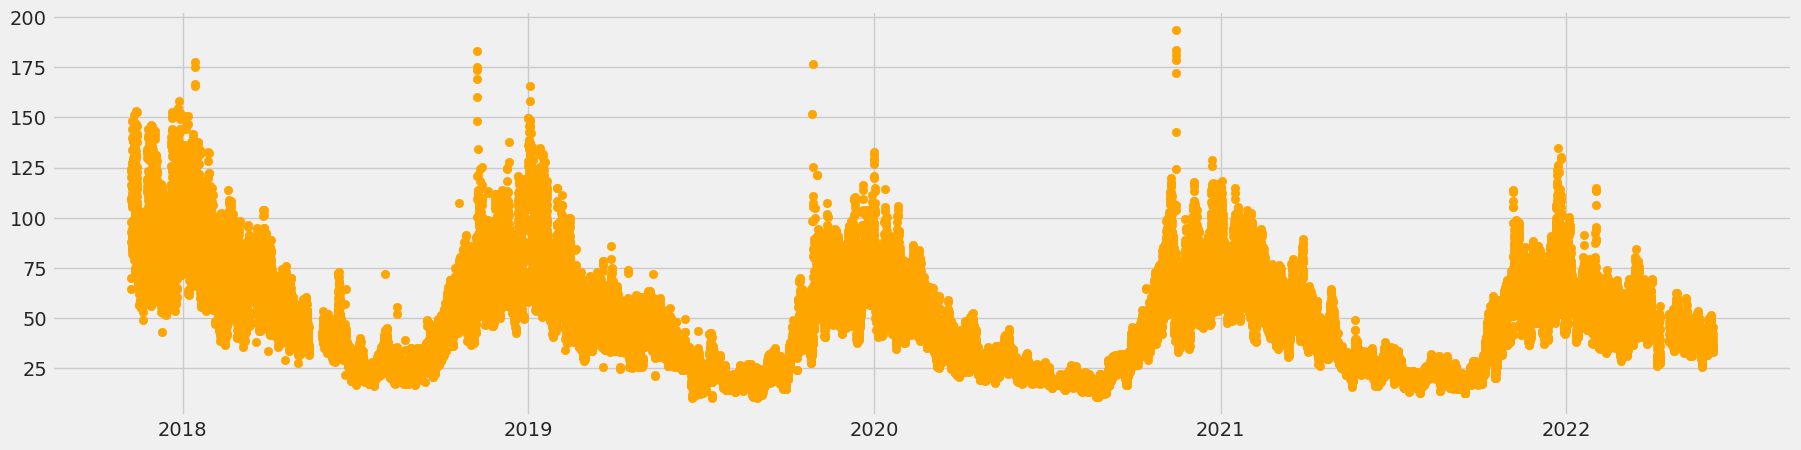

In [55]:
fig, ax = plt.subplots(figsize=(20, 5))
plt.scatter(y_pred_df.index, y_pred_df.pm, color='orange')

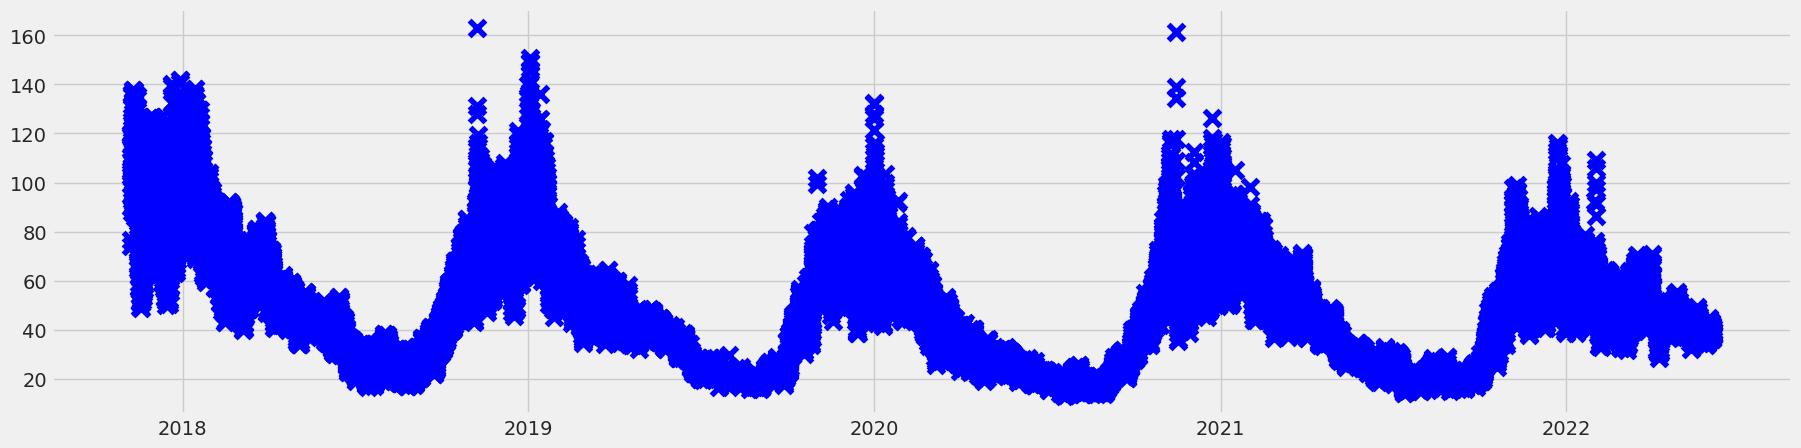

In [56]:
fig, ax = plt.subplots(figsize=(20, 5))
plt.scatter(y_pred_df.index, y_pred, s=130, marker='x', color='blue')

In [57]:
# Checking the last daate_time value of the main DataSet
df.index.max()

Timestamp('2022-06-04 15:00:00')

In [58]:
# Creating data_time indexes till the end of the year
future = pd.date_range('2022-06-05','2022-12-31', freq='1h')
print(future)

DatetimeIndex(['2022-06-05 00:00:00', '2022-06-05 01:00:00',
               '2022-06-05 02:00:00', '2022-06-05 03:00:00',
               '2022-06-05 04:00:00', '2022-06-05 05:00:00',
               '2022-06-05 06:00:00', '2022-06-05 07:00:00',
               '2022-06-05 08:00:00', '2022-06-05 09:00:00',
               ...
               '2022-12-30 15:00:00', '2022-12-30 16:00:00',
               '2022-12-30 17:00:00', '2022-12-30 18:00:00',
               '2022-12-30 19:00:00', '2022-12-30 20:00:00',
               '2022-12-30 21:00:00', '2022-12-30 22:00:00',
               '2022-12-30 23:00:00', '2022-12-31 00:00:00'],
              dtype='datetime64[ns]', length=5017, freq='H')


In [59]:
df.tail()

,hour,day_of_week,quarter,month,year,day_of_year,day_of_month,week_of_year,pm,lag1,lag2,lag3
Timestamp,,,,,,,,,,,,
2022-06-04 11:00:00,11,5,2,6,2022,155,4,22,35.89,23.49,19.53,27.59
2022-06-04 12:00:00,12,5,2,6,2022,155,4,22,33.83,22.21,20.26,27.39
2022-06-04 13:00:00,13,5,2,6,2022,155,4,22,33.05,22.44,20.96,28.79
2022-06-04 14:00:00,14,5,2,6,2022,155,4,22,35.29,23.45,21.34,29.38
2022-06-04 15:00:00,15,5,2,6,2022,155,4,22,40.67,24.05,24.12,27.93


In [60]:
# Creating DF where indexes are data-times from the future series
future_df = pd.DataFrame(index=future)

# Creating a column where flag is True if indexes are from future series
future_df['isFuture'] = True
# Creating the same with the original DataFrame, but with flag equels to False
df['isFuture'] = False
future_df.head()

,isFuture
2022-06-05 00:00:00,True
2022-06-05 01:00:00,True
2022-06-05 02:00:00,True
2022-06-05 03:00:00,True
2022-06-05 04:00:00,True


In [61]:
# Checkin the shape of the future :)
future.shape[0]

5017

In [62]:
# Let's concat these two DataFrames
original_df_plus_future = pd.concat([df, future_df])

original_df_plus_future = create_features(original_df_plus_future)
original_df_plus_future = add_lags(original_df_plus_future)
original_df_plus_future.head()

,hour,day_of_week,quarter,month,year,day_of_year,day_of_month,week_of_year,lag1,lag2,lag3,isFuture,pm
2017-11-07 12:00:00,12,1,4,11,2017,311,7,45,NaN,NaN,NaN,False,64.51
2017-11-07 13:00:00,13,1,4,11,2017,311,7,45,NaN,NaN,NaN,False,69.95
2017-11-07 14:00:00,14,1,4,11,2017,311,7,45,NaN,NaN,NaN,False,92.79
2017-11-07 15:00:00,15,1,4,11,2017,311,7,45,NaN,NaN,NaN,False,109.66
2017-11-07 16:00:00,16,1,4,11,2017,311,7,45,NaN,NaN,NaN,False,116.50


In [63]:
original_df_plus_future.tail()

,hour,day_of_week,quarter,month,year,day_of_year,day_of_month,week_of_year,lag1,lag2,lag3,isFuture,pm
2022-12-30 20:00:00,20,4,4,12,2022,364,30,52,71.56,104.38,68.12,True,NaN
2022-12-30 21:00:00,21,4,4,12,2022,364,30,52,70.27,104.19,66.65,True,NaN
2022-12-30 22:00:00,22,4,4,12,2022,364,30,52,66.78,99.09,61.09,True,NaN
2022-12-30 23:00:00,23,4,4,12,2022,364,30,52,61.29,95.64,57.32,True,NaN
2022-12-31 00:00:00,0,5,4,12,2022,365,31,52,58.18,92.77,53.74,True,NaN


In [64]:
# Creating new DataFrame that consists only future indexes with all made-before features
future_with_features = original_df_plus_future.query('isFuture').copy()
future_with_features.head()

#future_without_features['pred'] = reg.predict(original_df_plus_future[FEATURES])

,hour,day_of_week,quarter,month,year,day_of_year,day_of_month,week_of_year,lag1,lag2,lag3,isFuture,pm
2022-06-05 00:00:00,0,6,2,6,2022,156,5,22,23.95,21.49,NaN,True,NaN
2022-06-05 01:00:00,1,6,2,6,2022,156,5,22,24.42,21.82,NaN,True,NaN
2022-06-05 02:00:00,2,6,2,6,2022,156,5,22,26.37,22.26,NaN,True,NaN
2022-06-05 03:00:00,3,6,2,6,2022,156,5,22,28.34,23.36,NaN,True,NaN
2022-06-05 04:00:00,4,6,2,6,2022,156,5,22,30.17,24.17,NaN,True,NaN


In [65]:
future_with_features.shape

(5017, 13)

In [66]:
# Predicting
future_with_features['pm'] = reg.predict(future_with_features[FEATURES])

In [67]:
# Plotting
df_indexes_plus_pm = future_with_features['pm']
df_indexes_plus_pm.head()

2022-06-05 00:00:00    33.724648
2022-06-05 01:00:00    33.356529
2022-06-05 02:00:00    33.168839
2022-06-05 03:00:00    34.658348
2022-06-05 04:00:00    35.361439
Name: pm, dtype: float32

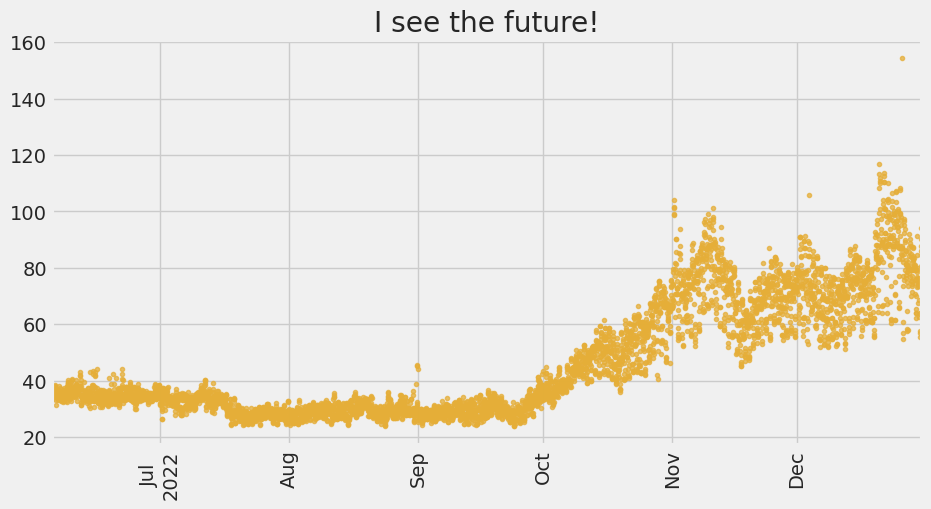

In [68]:
df_indexes_plus_pm.plot(style='.',
                        alpha=0.75, rot=90,
                        figsize=(10, 5),
                        color=color_pal[2],
                        title='I see the future!')
plt.show()

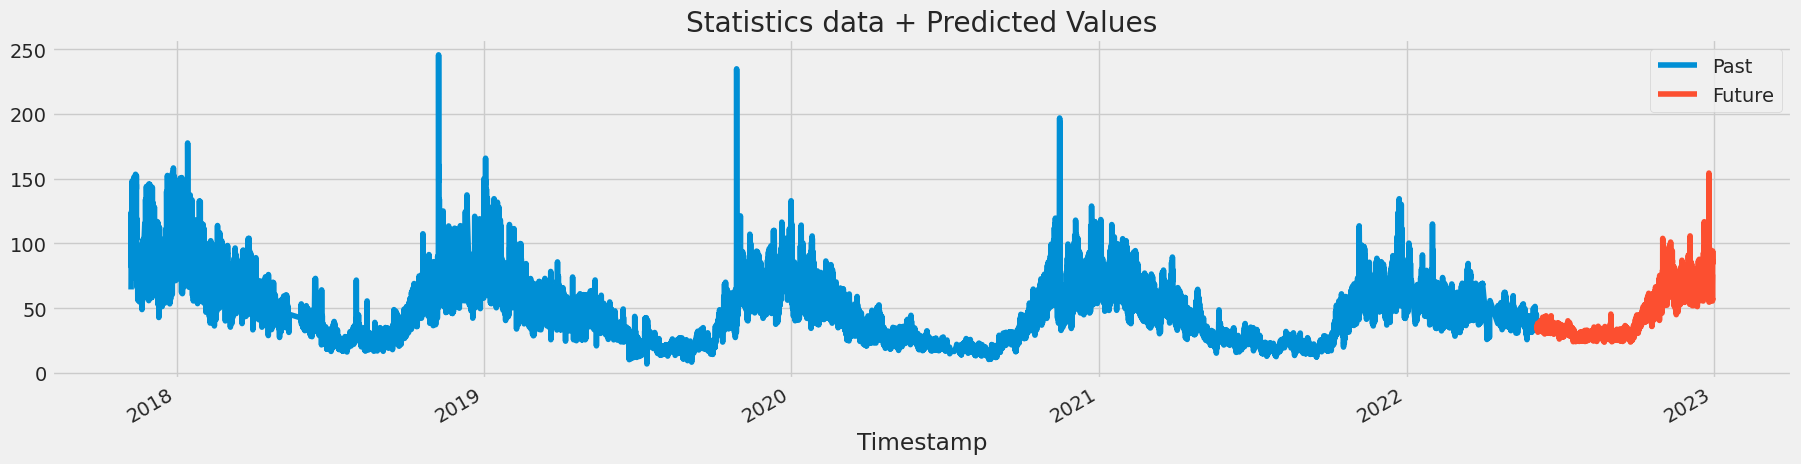

In [69]:
fig, ax = plt.subplots(figsize=(20, 5))
original_df.plot(ax=ax, label='Original DataSet', title='Statistics data + Predicted Values')
df_indexes_plus_pm.plot(ax=ax, label='Future Prediction')
ax.legend(['Past', 'Future'])
plt.show()

## Trying DessisionTreeRegression

In [70]:
FEATURES = [
        'hour',
        'day_of_week',
        'quarter',
        'month',
        'year',
        'day_of_year',
        'day_of_month',
        
        'week_of_year',
        ]

TARGET = 'pm'

In [71]:
dessision_tree_df = clear_df_plus_dt_features

x_data = dessision_tree_df [FEATURES]
y_data = dessision_tree_df [TARGET]

In [72]:
dessision_tree_df.head()

,hour,day_of_week,quarter,month,year,day_of_year,day_of_month,week_of_year,pm
Timestamp,,,,,,,,,
2017-11-07 12:00:00,12,1,4,11,2017,311,7,45,64.51
2017-11-07 13:00:00,13,1,4,11,2017,311,7,45,69.95
2017-11-07 14:00:00,14,1,4,11,2017,311,7,45,92.79
2017-11-07 15:00:00,15,1,4,11,2017,311,7,45,109.66
2017-11-07 16:00:00,16,1,4,11,2017,311,7,45,116.50


In [73]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=0)
Model = RandomForestRegressor()
Model.fit(x_train, y_train)

score = Model.score(x_train, y_train)

In [74]:
print(f"R-squared: {score:.3f}")

R-squared: 0.996


In [75]:
# Prediction
y_pred = Model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse:.3f}")
print(f"RMSE: {mse*(1/2.0):.3f}") 

MSE: 21.349
RMSE: 10.674


In [76]:
# Checking coefficient of determination of the model
print(f"Coefficient of Determination is equel to: {r2_score(y_pred, y_test):.4f}")

Coefficient of Determination is equel to: 0.9629


## Trying NeuralProphet

In [77]:
from neuralprophet import NeuralProphet

In [78]:
clear_df.head()

,pm
Timestamp,
2017-11-07 12:00:00,64.51
2017-11-07 13:00:00,69.95
2017-11-07 14:00:00,92.79
2017-11-07 15:00:00,109.66
2017-11-07 16:00:00,116.50


In [79]:
# Creating work DataFrame
work_df = clear_df.copy()
work_df.head()

,pm
Timestamp,
2017-11-07 12:00:00,64.51
2017-11-07 13:00:00,69.95
2017-11-07 14:00:00,92.79
2017-11-07 15:00:00,109.66
2017-11-07 16:00:00,116.50


In [80]:
# Creating proper columns
work_df['date'] = work_df.index
work_df['date'] = pd.to_datetime(work_df.date)
work_df.rename(columns={"date": "ds", "pm": "y"}, inplace=True)

# Mooving "y" column to the end
work_df = work_df.reindex(columns = [col for col in work_df.columns if col != 'y'] + ['y'])
work_df.head()

,ds,y
Timestamp,,
2017-11-07 12:00:00,2017-11-07 12:00:00,64.51
2017-11-07 13:00:00,2017-11-07 13:00:00,69.95
2017-11-07 14:00:00,2017-11-07 14:00:00,92.79
2017-11-07 15:00:00,2017-11-07 15:00:00,109.66
2017-11-07 16:00:00,2017-11-07 16:00:00,116.50


In [81]:
work_df.describe()

,y
count,36175.000000
mean,49.274402
std,24.710494
min,10.210000
25%,28.090000
50%,45.730000
75%,64.510000
max,193.800000


In [82]:
# Training model
model = NeuralProphet()
metrics = model.fit(work_df, freq="D")

# Creating future dates and predicting
future = model.make_future_dataframe(work_df, periods=365, n_historic_predictions=len(work_df)) 
forecast = model.predict(future)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 97.977% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency D is different than major frequency H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 74


  0%|          | 0/163 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.81E-02, min: 6.81E-01


  0%|          | 0/163 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.81E-02, min: 7.74E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 7.74E-02
Epoch[74/74]: 100%|██████████| 74/74 [00:48<00:00,  1.51it/s, SmoothL1Loss=0.00825, MAE=8.03, RMSE=10.8, Loss=0.00589, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 97.977% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency D is different than major frequency H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 96.998% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency D is different than major frequency H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 96.998% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency D is different than major frequency H
INFO - (NP.df_utils.ret

Text(0.5, 1.0, 'Air Quality')

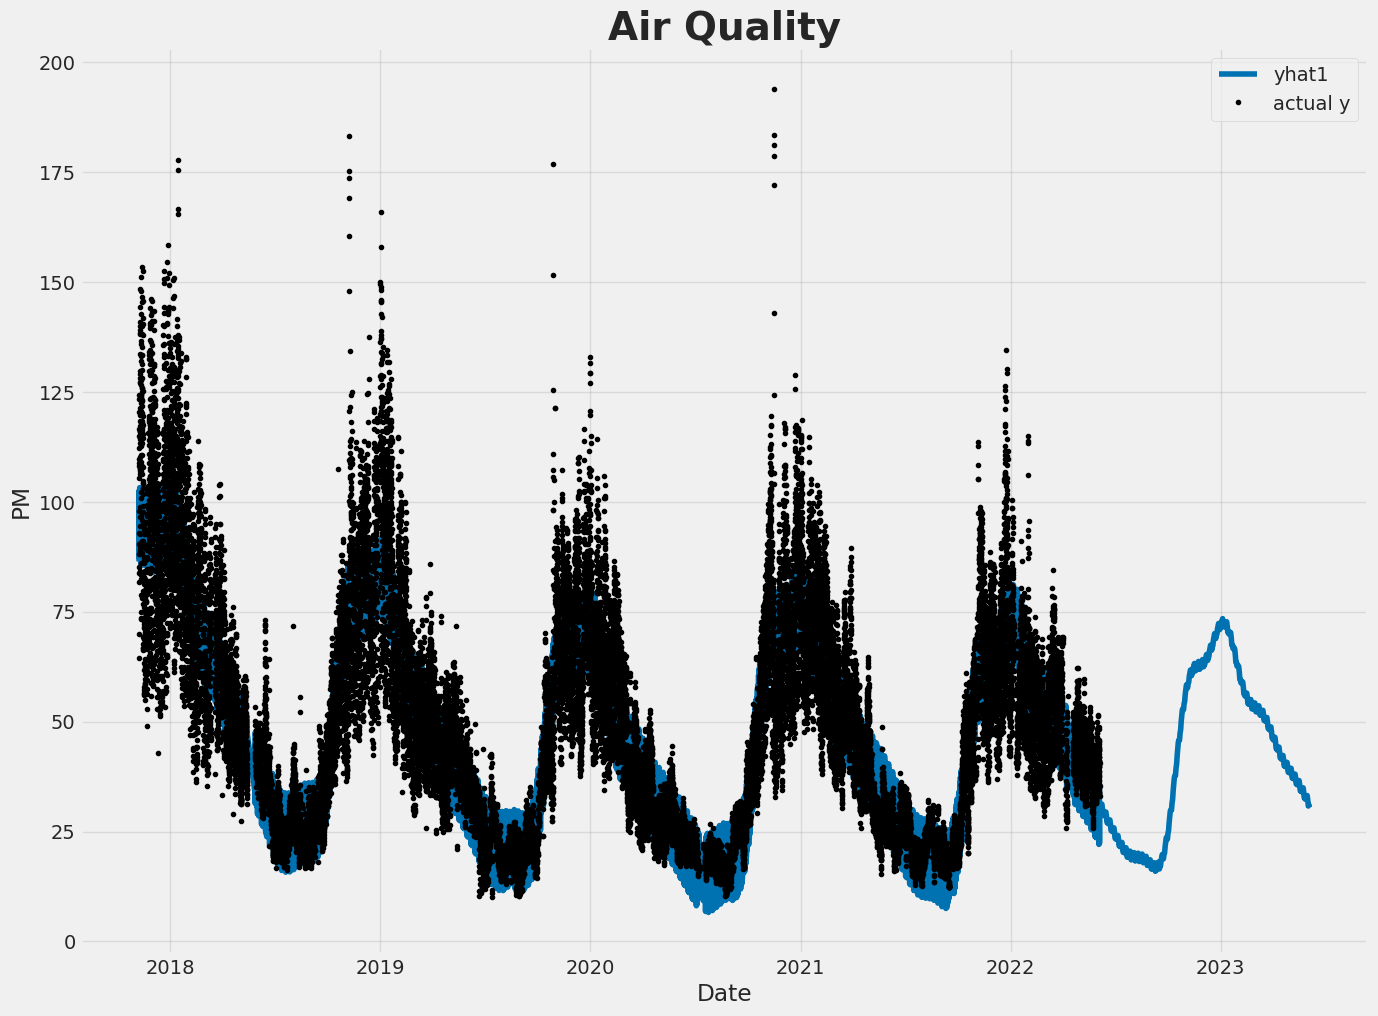

In [83]:
#PLotting real data and predicted values PLUS furure
fig, ax = plt.subplots(figsize=(14, 10)) 
model.plot(forecast, xlabel="Date", ylabel="PM", ax=ax)
ax.set_title("Air Quality", fontsize=28, fontweight="bold")

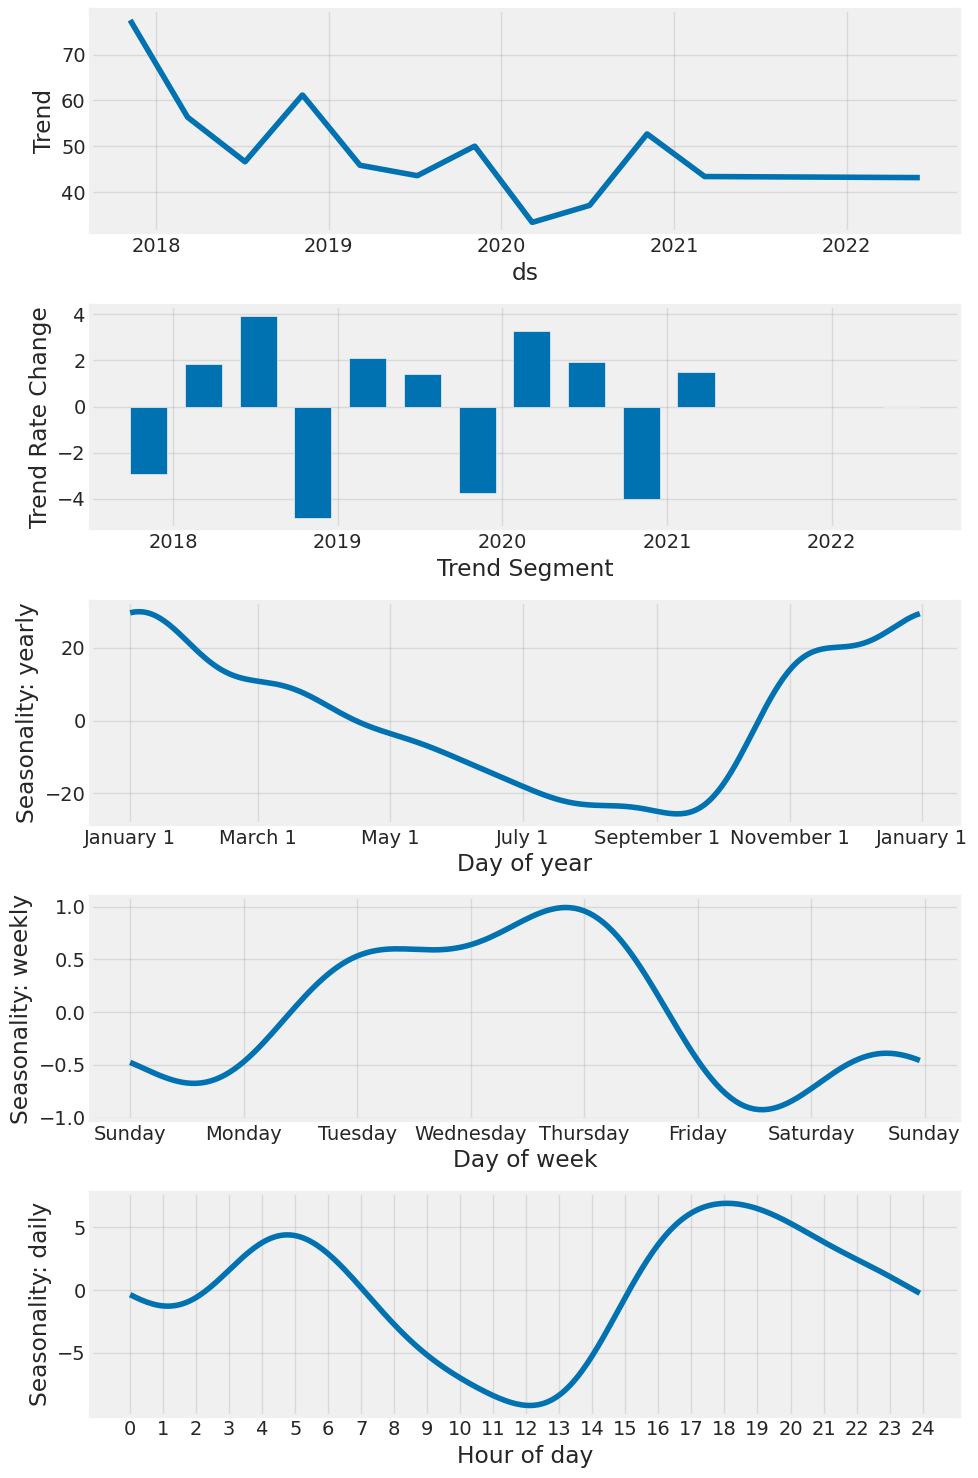

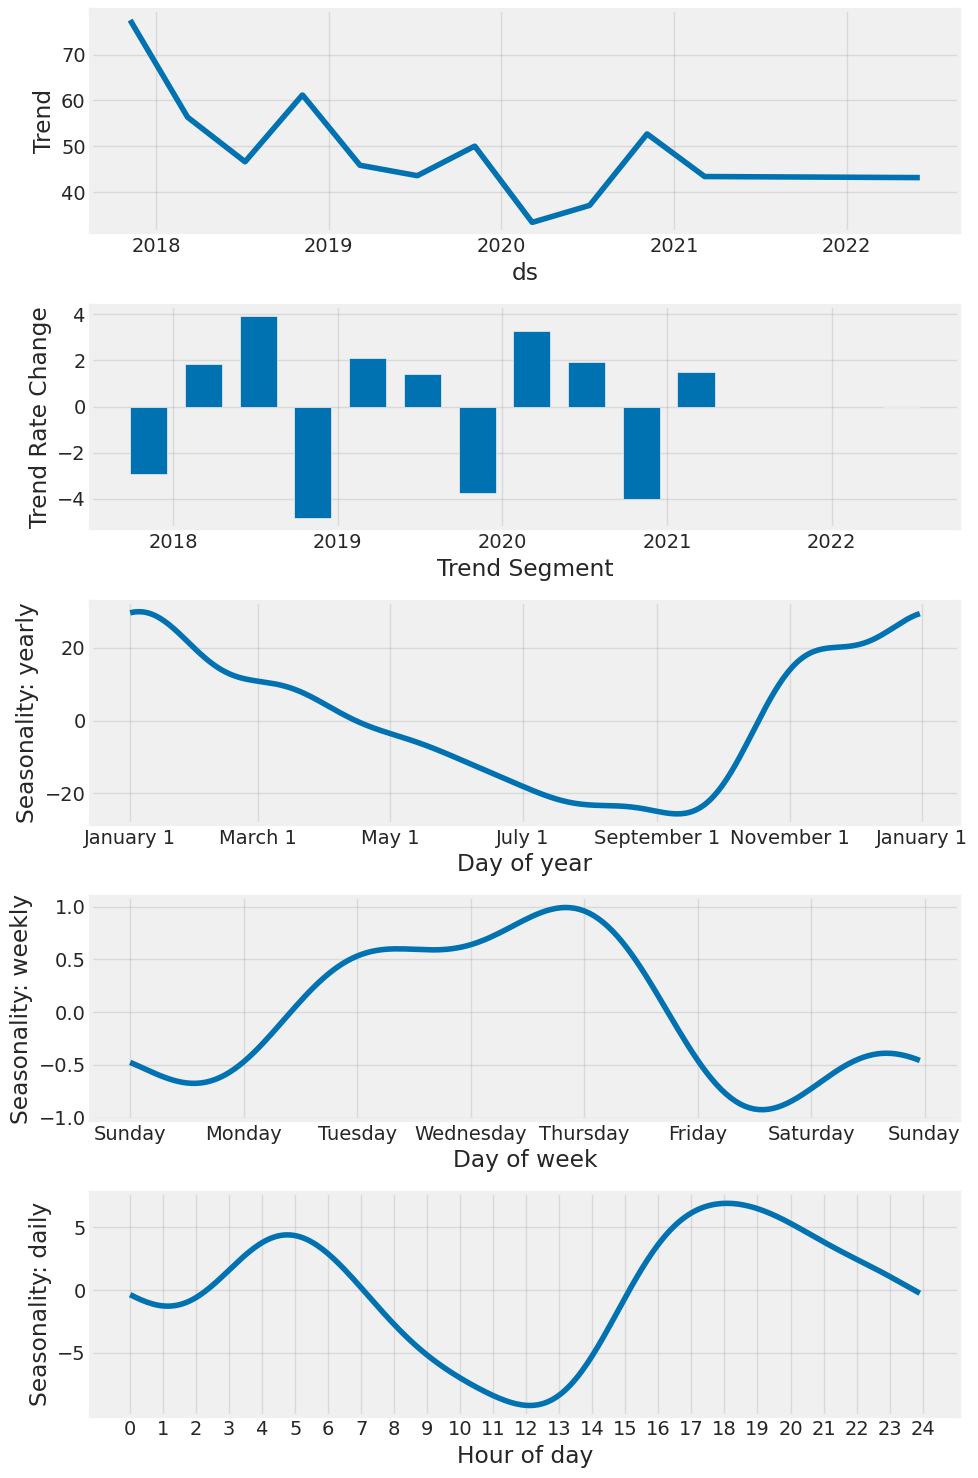

In [84]:
model.plot_parameters()

In [85]:
metrics.columns

Index(['SmoothL1Loss', 'MAE', 'RMSE', 'Loss', 'RegLoss'], dtype='object')

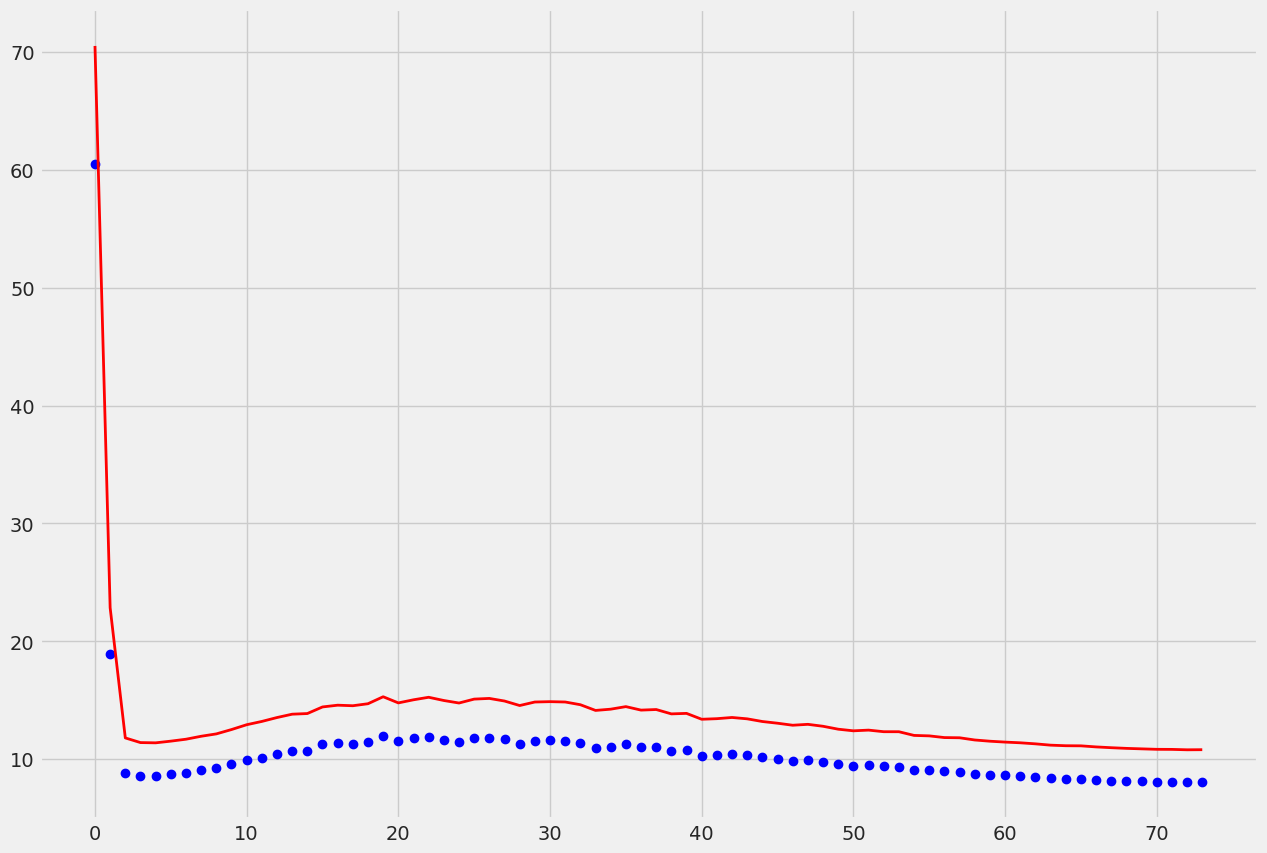

In [86]:

fig, ax = plt.subplots(figsize=(14, 10))
ax.plot(metrics["MAE"], 'ob', linewidth=6, label="Training Loss")  
ax.plot(metrics["RMSE"], '-r', linewidth=2, label="Validation Loss")

In [89]:
metrics.head(10)

,SmoothL1Loss,MAE,RMSE,Loss,RegLoss
0,0.338550,60.486151,70.519142,0.255254,0.0
1,0.041066,18.916402,22.846054,0.030332,0.0
2,0.009840,8.786891,11.800076,0.006986,0.0
3,0.009199,8.544161,11.404039,0.006589,0.0
4,0.009154,8.565372,11.383234,0.006574,0.0
5,0.009395,8.700076,11.526243,0.006770,0.0
6,0.009650,8.829581,11.690085,0.006961,0.0
7,0.010059,9.049045,11.940826,0.007279,0.0
8,0.010402,9.257106,12.141451,0.007538,0.0
9,0.011052,9.550015,12.509619,0.008032,0.0
